On-Time Benchmark

In [2]:
# SQL:
# select
#   tasks.merchant_id,
#   tasks.env,
#   tasks.id as task_id,
#   wp.original_eta,
#   wp.checkin_time,
#   date_diff('minute',original_eta,checkin_time) as on_time
# from tasks
# join way_points as wp on tasks.id = wp.task_id and wp.date >= 20250101 and wp.checkin_time between date '2025-03-01' and date '2025-04-30' and wp.env = tasks.env
# join merchants on merchants.id = tasks.merchant_id and merchants.env = tasks.env and merchants.subscription_type = 17
# where tasks.date >= 20250101
#   and tasks.status = 4
#   and tasks.task_type_id <>3
#   and tasks.ended_time between date '2025-04-01' and date '2025-04-30'
#   and tasks.merchant_id <> 6
#   and tasks.is_billable = 1
#   and (
#       (tasks.task_type_id = 2 and wp.pickup_dropoff_option = 0) OR
#       (tasks.task_type_id in (4,5) and wp.pickup_dropoff_option in (1,2)) OR
#       (merchants.partner_id = 875 and wp.position = 1)
#       )
#   and original_eta is not null

PreProcessing

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df1 = pd.read_csv('/Users/along/Documents/Analysis/Benchmarks/ontimev1.csv',index_col= 'task_id').sample(frac=0.1)
df2 = pd.read_csv('/Users/along/Documents/Analysis/Benchmarks/ontimev2.csv',index_col= 'task_id').sample(frac=0.1)
accounts = pd.read_csv('/Users/along/Documents/Analysis/Benchmarks/accounts.csv')

In [5]:
# create a sample data frame with account information

df_sample = pd.concat([df1,df2])
df_sample = df_sample.merge(accounts,on=['merchant_id','env'])
df_sample.head()

,merchant_id,env,run_id,wp_id,original_eta,checkin_time,on_time,name,industry,use_case
0,6,prod_us2,210384904.0,648184657,2025-04-15 12:30:36.000 UTC,2025-04-15 12:29:51.333 UTC,0,AutoZone,General Retail,On-Demand Parcel
1,6,prod_us2,211523178.0,653681316,2025-04-23 22:40:24.000 UTC,2025-04-23 22:44:09.595 UTC,3,AutoZone,General Retail,On-Demand Parcel
2,6,prod_us2,212185247.0,653401233,2025-04-29 16:53:28.534 UTC,2025-04-29 16:25:56.422 UTC,-27,AutoZone,General Retail,On-Demand Parcel
3,6,prod_us2,211493265.0,653560714,2025-04-23 20:06:24.000 UTC,2025-04-23 19:38:07.384 UTC,-28,AutoZone,General Retail,On-Demand Parcel
4,6,prod_us2,211978092.0,655552398,2025-04-28 12:13:36.000 UTC,2025-04-28 12:14:30.348 UTC,0,AutoZone,General Retail,On-Demand Parcel


In [6]:
# Remove names with less than 1000 rows

# Get the counts of each name
name_counts = df_sample['name'].value_counts()

# Filter names with less than 1000 rows
names_to_keep = name_counts[name_counts >= 1000].index

# Filter the DataFrame
df_sample = df_sample[df_sample['name'].isin(names_to_keep)]

Removing Outliers

In [7]:
def get_lower_bound(series):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    return pd.Series([q1 - 1.5 * iqr] * len(series), index=series.index)

def get_upper_bound(series):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    return pd.Series([q3 + 1.5 * iqr] * len(series), index=series.index)

# Apply transform for each bound
df_sample['lower_bound'] = df_sample.groupby('name')['on_time'].transform(get_lower_bound)
df_sample['upper_bound'] = df_sample.groupby('name')['on_time'].transform(get_upper_bound)


In [46]:
# Remove outliers of on-time using iqr
def metrics(item):
  on_time = item[(item['on_time'] >= item['lower_bound']) & (item['on_time'] <= item['upper_bound'])]['on_time']

  #Compute Metrics
  tasks = on_time.count()
  outliers = 1 - (tasks / item['on_time'].count())
  avg = on_time.mean()
  abs_avg = abs(on_time).mean()
  std = abs(on_time).std()
  cv = std/abs_avg
  skew = on_time.skew()
  kurt = on_time.kurt()

  #Return Values
  return pd.Series({'Tasks' : tasks,
                    'Outliers' : outliers,
                    'ABS Avg' : abs_avg,
                    'Std' : std,
                    'CV' : cv,
                    'skew' : skew,
                    'kurt' : kurt})

df_sample.groupby(['name']).apply(metrics,include_groups=False).style.format({'Tasks' : '{:,.0f}','Outliers' : '{:.0%}','ABS Avg': '{:.2f}', 'Std' : '{:.2f}', 'CV' : '{:.2f}', 'skew' : '{:.2f}', 'kurt' : '{:.2f}'})

,Tasks,Outliers,ABS Avg,Std,CV,skew,kurt
name,,,,,,,
AAA,"29,212",9%,5.55,5.81,1.05,0.85,1.03
ADEO,"9,302",17%,413.71,731.32,1.77,1.66,4.26
AnyVan,"2,123",15%,23.90,24.88,1.04,-0.30,0.61
Armour Courier Services Inc.,"6,831",16%,90.81,82.12,0.90,0.28,0.72
Asda,"11,148",6%,14.38,10.36,0.72,0.06,0.09
AutoZone,"348,977",16%,5.35,5.04,0.94,0.34,0.31
Best Buy,"33,239",7%,30.40,23.00,0.76,0.23,0.14
Boulanger,"10,098",6%,37.19,30.04,0.81,-0.11,-0.03
Burger King Corp (RBI),"20,392",4%,13.50,7.03,0.52,0.29,-0.23


On Time Rate

In [48]:
# Getting On-Time Rate for each time window
def on_time_rate(group, time_window = 15):
  timeAgg = group['on_time']
  on_time_count = (timeAgg.lt(time_window) & timeAgg.gt(-time_window)).sum()
  total_count = timeAgg.count()
  on_time_rate = round(on_time_count/total_count,2)

  return pd.Series({'onTimeRate' : on_time_rate, 'Total Counts' : total_count*10})

In [49]:
# Getting On-Time Rate for a list of time windows for a group (industry, use_case, name)
def get_group_rate(group):
    time_buckets = [1,5,10,15,30,60,120,180,360]
    group_ontime = pd.DataFrame()

    for time_bucket in time_buckets:
        group_ontime[time_bucket] = df_sample.groupby(group).apply(on_time_rate,time_bucket,include_groups=False)['onTimeRate']

    return group_ontime


In [50]:
merchant_ontime = get_group_rate('name')
industry_ontime = get_group_rate('industry')
use_case_ontime = get_group_rate('use_case')


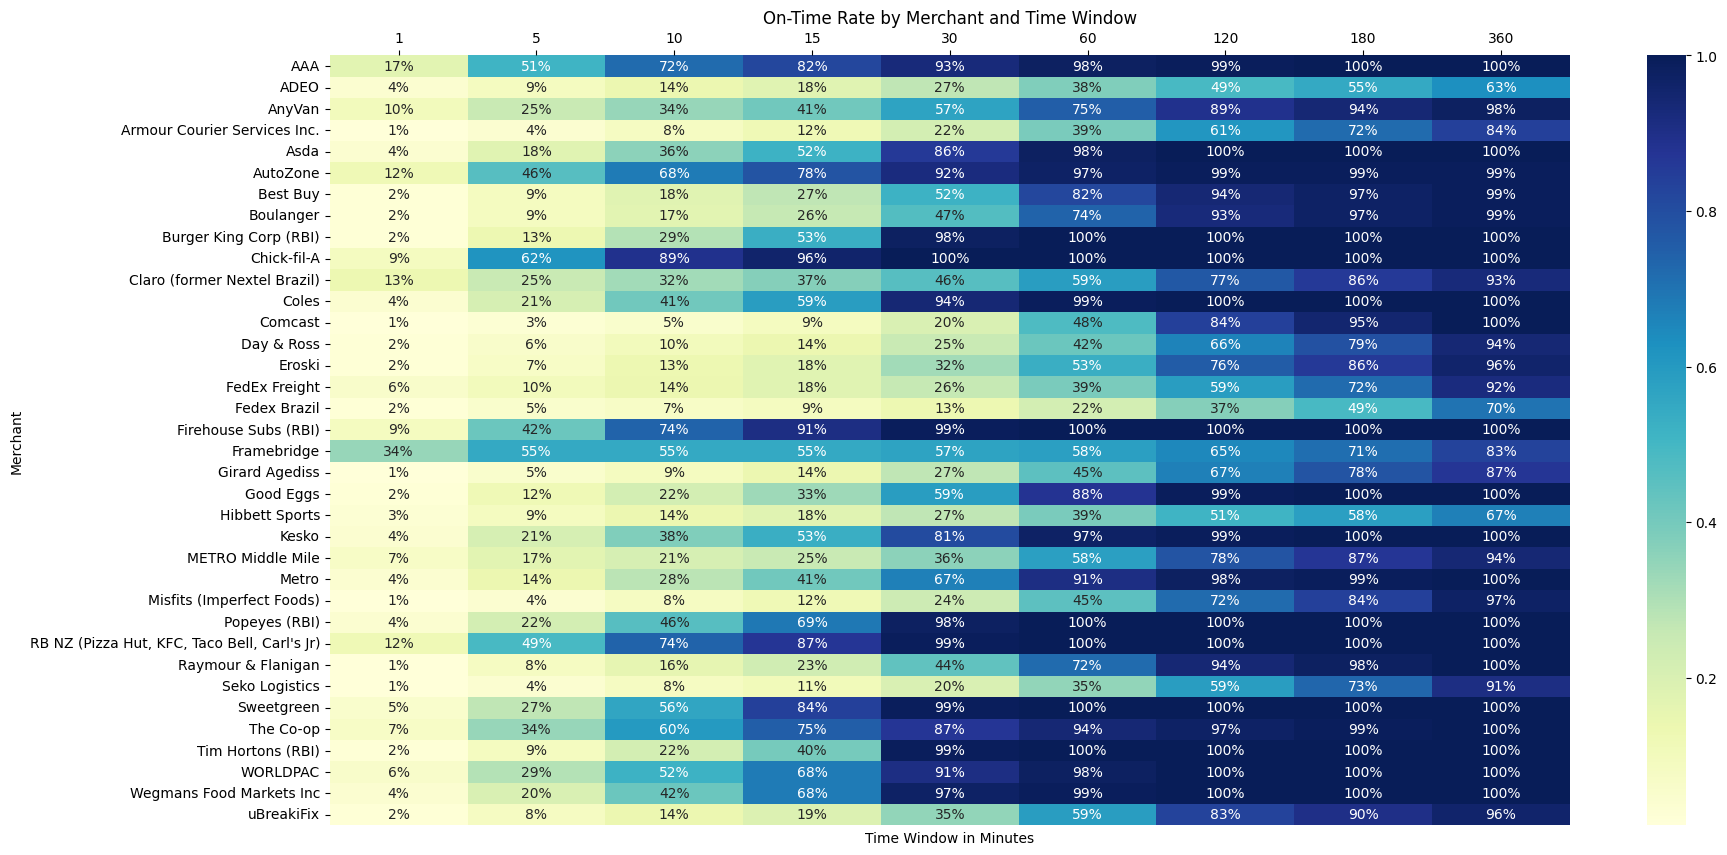

In [51]:
plt.figure(figsize=(20, 10))
sns.heatmap(merchant_ontime, annot=True, fmt=".0%", cmap="YlGnBu")
plt.title('On-Time Rate by Merchant and Time Window')
plt.xlabel('Time Window in Minutes')
plt.ylabel('Merchant')
plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)

plt.show()

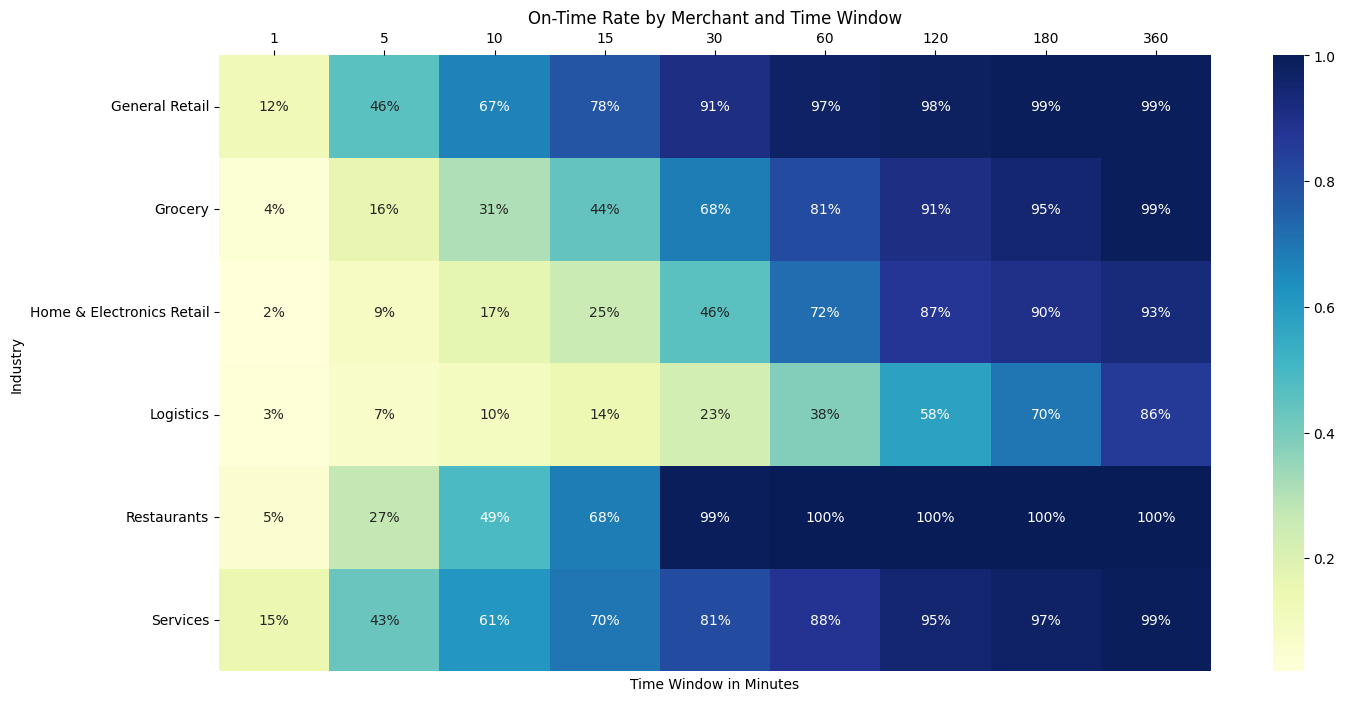

In [39]:
plt.figure(figsize=(16, 8))
sns.heatmap(industry_ontime, annot=True, fmt=".0%", cmap="YlGnBu")
plt.title('On-Time Rate by Merchant and Time Window')
plt.xlabel('Time Window in Minutes')
plt.ylabel('Industry')
plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)

plt.show()

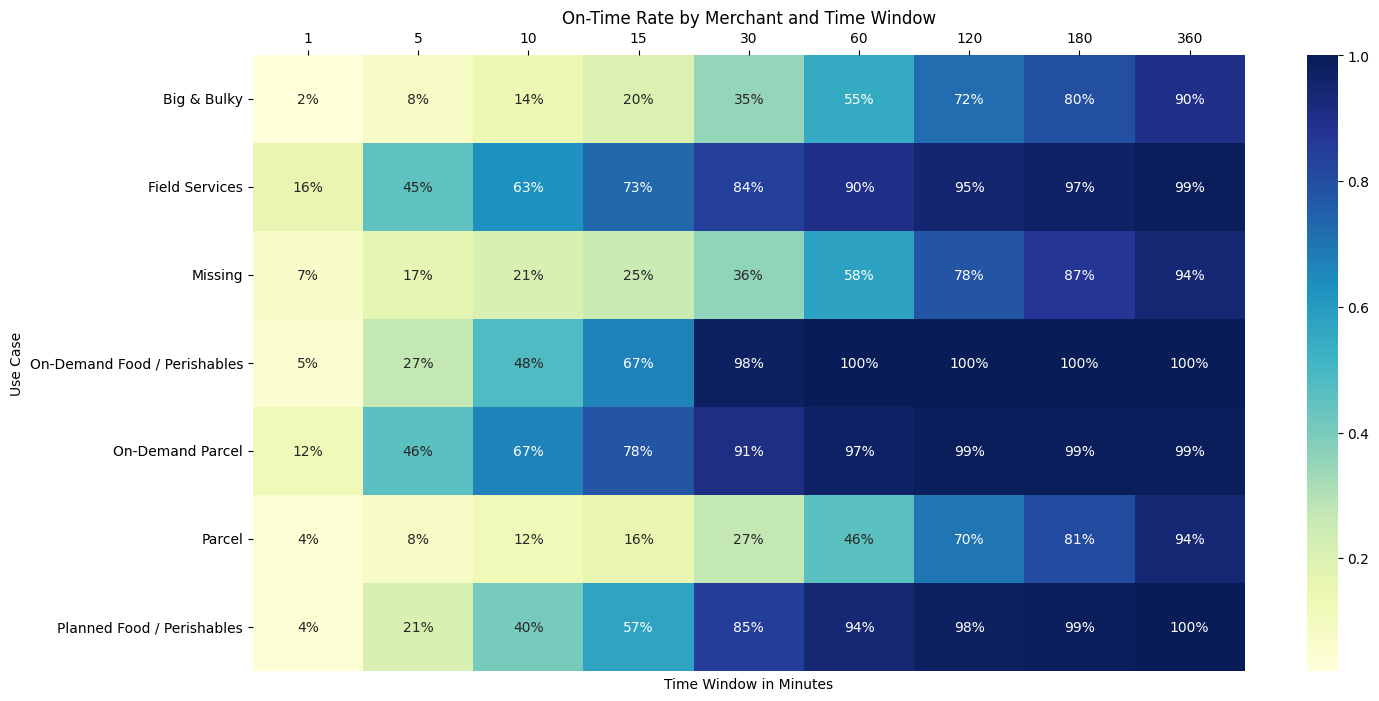

In [40]:
plt.figure(figsize=(16, 8))
sns.heatmap(use_case_ontime, annot=True, fmt=".0%", cmap="YlGnBu")
plt.title('On-Time Rate by Merchant and Time Window')
plt.xlabel('Time Window in Minutes')
plt.ylabel('Use Case')
plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)

plt.show()